
# ♻️ TrashNet Image Classification (PyTorch + timm)

**Dataset:** [TrashNet] — 6 classes: `cardboard, glass, metal, paper, plastic, trash`  
**Goal:** Train a CNN classifier using **PyTorch + timm**.

## 📊 Grading - Points awarded noted below
<mark> Please do not check in any additional image or zip files or folders or your model in please.  Our gitlab server does not have the space (automatic 5 point grade deduction)<br>
Please put all your work in this file, each answer following each numbered section


## 0) Setup

In [4]:

# If timm isn't installed, uncomment:
!pip install timm --quiet

import os, random, time
from pathlib import Path
from typing import Tuple, List

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset

from torchvision import datasets
import timm

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# === Set your data root to the folder that contains train/ valid/ (and optional test/) ===
DATA_ROOT = Path('./data_root')  # 


Device: cuda



## 1) Get the data(**10 pts**)



In [7]:
#get the dataset from kaggle, you need an account, the cli installed and a proper kaggle.json authentication file in ~/.kaggle
#see https://www.kaggle.com/docs/api for more details
!kaggle datasets download feyzazkefe/trashnet

Dataset URL: https://www.kaggle.com/datasets/feyzazkefe/trashnet
License(s): unknown
  0%|                                               | 0.00/40.8M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 40.8M/40.8M [00:00<00:00, 1.39GB/s]


In [8]:
#unzip the dataset into the data_root folder, should create a single folder called dataset-resized, with subfolders for each class
!unzip trashnet.zip -d data_root

Archive:  trashnet.zip
  inflating: data_root/dataset-resized/cardboard/cardboard1.jpg  
  inflating: data_root/dataset-resized/cardboard/cardboard10.jpg  
  inflating: data_root/dataset-resized/cardboard/cardboard100.jpg  
  inflating: data_root/dataset-resized/cardboard/cardboard101.jpg  
  inflating: data_root/dataset-resized/cardboard/cardboard102.jpg  
  inflating: data_root/dataset-resized/cardboard/cardboard103.jpg  
  inflating: data_root/dataset-resized/cardboard/cardboard104.jpg  
  inflating: data_root/dataset-resized/cardboard/cardboard105.jpg  
  inflating: data_root/dataset-resized/cardboard/cardboard106.jpg  
  inflating: data_root/dataset-resized/cardboard/cardboard107.jpg  
  inflating: data_root/dataset-resized/cardboard/cardboard108.jpg  
  inflating: data_root/dataset-resized/cardboard/cardboard109.jpg  
  inflating: data_root/dataset-resized/cardboard/cardboard11.jpg  
  inflating: data_root/dataset-resized/cardboard/cardboard110.jpg  
  inflating: data_root/datase


## 2) Split the data in train and valid folders (**10 pts**)

split dataset-resized folder into seperate train and valid folders (80/20 split)

**File Structure expected when done(ImageFolder layout):**
```
data_root/
  train/
    cardboard/*.jpg
    glass/*.jpg
    metal/*.jpg
    paper/*.jpg
    plastic/*.jpg
    trash/*.jpg
  valid/
    cardboard/*.jpg
    glass/*.jpg
    metal/*.jpg
    paper/*.jpg
    plastic/*.jpg
    trash/*.jpg


In [12]:
import os
import shutil
import random

random.seed(42)

# Use your actual root folder name
data_root = "data_root"
src_root = os.path.join(data_root, "dataset-resized")  # or "data_resized" if that's what you see
train_root = os.path.join(data_root, "train")
valid_root = os.path.join(data_root, "valid")

os.makedirs(train_root, exist_ok=True)
os.makedirs(valid_root, exist_ok=True)

for class_name in os.listdir(src_root):
    class_path = os.path.join(src_root, class_name)
    if not os.path.isdir(class_path):
        continue
    
    images = os.listdir(class_path)
    random.shuffle(images)
    split_idx = int(0.8 * len(images))

    train_imgs = images[:split_idx]
    valid_imgs = images[split_idx:]

    os.makedirs(os.path.join(train_root, class_name), exist_ok=True)
    os.makedirs(os.path.join(valid_root, class_name), exist_ok=True)

    for img in train_imgs:
        shutil.copy2(os.path.join(class_path, img),
                     os.path.join(train_root, class_name, img))
    for img in valid_imgs:
        shutil.copy2(os.path.join(class_path, img),
                     os.path.join(valid_root, class_name, img))

print("✅ Dataset split complete!")



✅ Dataset split complete!



## 3) Create datasets with timm transforms (**10 pts**)

- Choose 'convnext_tiny' model and get  **train/valid transforms** that match its expected input (used to resize and normalize images).  
- make sure to normalize all images 



In [14]:
import torch
from torchvision import datasets, transforms
import timm
from timm.data import create_transform
from timm.data import resolve_data_config
MODEL_NAME = 'convnext_tiny'
# Get model configuration
config = resolve_data_config({}, model=MODEL_NAME)

# Create transforms matching model's expected input
train_transform = create_transform(**config, is_training=True)
valid_transform = create_transform(**config, is_training=False)
from torchvision import datasets

train_dataset = datasets.ImageFolder(
    root='data_root/train',
    transform=train_transform
)

valid_dataset = datasets.ImageFolder(
    root='data_root/valid',
    transform=valid_transform
)
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2)
images, labels = next(iter(train_loader))
print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)
print("Image min/max values:", images.min().item(), images.max().item())


Image batch shape: torch.Size([64, 3, 224, 224])
Label batch shape: torch.Size([64])
Image min/max values: -2.1179039478302 2.640000104904175



## 4) Create DataLoaders (**10 pts**)

- Shuffle the training loader; keep validation loader deterministic.  
- Adjust `BATCH_SIZE` to fit your GPU/CPU memory.


In [18]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 🔧 Define ConvNeXt transforms (resize + normalize)
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# 📂 Load from your organized folders
train_dataset = datasets.ImageFolder(root="data_root/train", transform=train_transform)
val_dataset   = datasets.ImageFolder(root="data_root/valid", transform=val_transform)

print(f"✅ Classes: {train_dataset.classes}")
BATCH_SIZE = 32  # reduce to 16 if GPU memory is tight

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✅ Train loader: {len(train_loader)} batches | Val loader: {len(val_loader)} batches")


✅ Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
✅ Train loader: 64 batches | Val loader: 16 batches



## 5) Load timm model (transfer learning) (**10 pts**)

- Create a **pretrained** model with `num_classes` = 6 (TrashNet).  


In [19]:
import timm
import torch.nn as nn

# Create pretrained ConvNeXt Tiny model
model = timm.create_model(
    "convnext_tiny",
    pretrained=True,
    num_classes=6   # TrashNet has 6 classes
)

print("✅ Loaded ConvNeXt Tiny with 6 output classes")





✅ Loaded ConvNeXt Tiny with 6 output classes


In [20]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.01)

criterion = torch.nn.CrossEntropyLoss()
images, labels = next(iter(train_loader))
print(images.device, labels.device)


cpu cpu


## 6) Optimizer & loss **(5 pts)**

- use crossentropy and adam
- Start with a Learning rate = 0.01
- train for 5 epochs only (gives good quality ball park)

In [37]:
import torch, gc
del model  # remove old model from memory
gc.collect()
torch.cuda.empty_cache()


In [38]:
import timm, torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model("convnext_tiny", pretrained=True, num_classes=6)
model = model.half().to(device)     # ✅ half precision to save memory


In [39]:
for images, labels in train_loader:
    images = images.to(device).half()   # ✅ cast to half
    labels = labels.to(device)
    outputs = model(images)
    ...


In [40]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=2)


In [42]:
print(torch.cuda.memory_summary(device=None, abbreviated=True))


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 8            |        cudaMalloc retries: 9         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1960 MiB |   7467 MiB | 137440 MiB | 135479 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   1960 MiB |   7467 MiB | 137440 MiB | 135479 MiB |
|---------------------------------------------------------------------------|
| Requested memory      |   1946 MiB |   7443 MiB | 137052 MiB | 135105 MiB |
|---------------------------------------------------------------

In [21]:
#create optimizer and loss function
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm import tqdm
import timm
from timm.data import create_transform
from torch.cuda.amp import autocast, GradScaler

# -----------------------------------------------------------
# ⚙️ 1. Device setup
# -----------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# -----------------------------------------------------------
# 🧩 2. Transforms (resize smaller for speed)
# -----------------------------------------------------------
train_transform = create_transform(input_size=128, is_training=True)
valid_transform = create_transform(input_size=128, is_training=False)

train_dataset = datasets.ImageFolder("data_root/train", transform=train_transform)
valid_dataset = datasets.ImageFolder("data_root/valid", transform=valid_transform)

# -----------------------------------------------------------
# 🚀 3. DataLoaders (parallel loading + pinned memory)
# -----------------------------------------------------------
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False,
                          num_workers=2, pin_memory=True)

# -----------------------------------------------------------
# 🧠 4. Model (freeze backbone for speed)
# -----------------------------------------------------------
model = timm.create_model("convnext_tiny", pretrained=True, num_classes=6)

for param in model.parameters():
    param.requires_grad = False
for param in model.get_classifier().parameters():
    param.requires_grad = True

model = model.to(device)

# -----------------------------------------------------------
# 🎯 5. Loss, optimizer, scaler
# -----------------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()  # mixed precision gradient manager

# -----------------------------------------------------------
# 🔁 6. Training loop with AMP
# -----------------------------------------------------------
EPOCHS = 5
for epoch in range(EPOCHS):
    print(f"\nEpoch [{epoch+1}/{EPOCHS}]")
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # ----- TRAIN -----
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        with autocast():  # ✅ mixed precision
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    # ----- VALIDATION -----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad(), autocast():
        for images, labels in tqdm(valid_loader, desc="Validation", leave=False):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc*100:.2f}%")

print("\n🎉 Training complete (fast AMP version)!")



✅ Using device: cuda


/tmp/ipykernel_11199/3307469659.py:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # mixed precision gradient manager



Epoch [1/5]


Training:   0%|                                         | 0/127 [00:00<?, ?it/s]/tmp/ipykernel_11199/3307469659.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ mixed precision
/tmp/ipykernel_11199/3307469659.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
                                                                                

Train Loss: 0.7199 | Train Acc: 73.95%
Val   Loss: 0.4499 | Val   Acc: 85.83%

Epoch [2/5]


Train Loss: 0.4984 | Train Acc: 82.42%
Val   Loss: 0.4232 | Val   Acc: 86.02%

Epoch [3/5]


Train Loss: 0.4387 | Train Acc: 84.25%
Val   Loss: 0.4069 | Val   Acc: 85.83%

Epoch [4/5]


Train Loss: 0.3857 | Train Acc: 86.63%
Val   Loss: 0.3737 | Val   Acc: 86.22%

Epoch [5/5]


Train Loss: 0.3334 | Train Acc: 88.21%
Val   Loss: 0.3636 | Val   Acc: 87.80%

🎉 Training complete (fast AMP version)!



## 7) Training & validation loop (**10 pts**)

- create train_one_epoch **function**
- create evaluate **function**
- create train_and_evaluate **function** that calls train_one_epoch and evaluate  once per epoch



In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm import tqdm
import timm
from timm.data import create_transform
from torch.cuda.amp import autocast, GradScaler

# -----------------------------------------------------------
# ⚙️ Setup
# -----------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Transforms
train_transform = create_transform(input_size=128, is_training=True)
valid_transform = create_transform(input_size=128, is_training=False)

train_dataset = datasets.ImageFolder("data_root/train", transform=train_transform)
valid_dataset = datasets.ImageFolder("data_root/valid", transform=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

# Model
model = timm.create_model("convnext_tiny", pretrained=True, num_classes=6)

# Freeze backbone (optional)
for param in model.parameters():
    param.requires_grad = False
for param in model.get_classifier().parameters():
    param.requires_grad = True

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()

# -----------------------------------------------------------
# 🏋️ 1) train_one_epoch()
# -----------------------------------------------------------
def train_one_epoch(model, dataloader, optimizer, criterion, scaler, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# -----------------------------------------------------------
# 📊 2) evaluate()
# -----------------------------------------------------------
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad(), autocast():
        for images, labels in tqdm(dataloader, desc="Validation", leave=False):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# -----------------------------------------------------------
# 🔁 3) train_and_evaluate()
# -----------------------------------------------------------
def train_and_evaluate(model, train_loader, valid_loader, optimizer, criterion, scaler, device, epochs=5):
    for epoch in range(epochs):
        print(f"\nEpoch [{epoch+1}/{epochs}]")
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler, device)
        val_loss, val_acc = evaluate(model, valid_loader, criterion, device)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc*100:.2f}%")

    print("\n🎉 Training complete!")

# -----------------------------------------------------------
# 🚀 Run training
# -----------------------------------------------------------
train_and_evaluate(model, train_loader, valid_loader, optimizer, criterion, scaler, device, epochs=5)



✅ Using device: cuda


/tmp/ipykernel_11199/1199830923.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Epoch [1/5]


Training:   0%|                                         | 0/127 [00:00<?, ?it/s]/tmp/ipykernel_11199/1199830923.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_11199/1199830923.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
                                                                                

Train Loss: 0.7076 | Train Acc: 74.29%
Val   Loss: 0.4494 | Val   Acc: 83.66%

Epoch [2/5]


Train Loss: 0.4717 | Train Acc: 84.70%
Val   Loss: 0.4265 | Val   Acc: 83.66%

Epoch [3/5]


Train Loss: 0.4383 | Train Acc: 84.45%
Val   Loss: 0.3853 | Val   Acc: 87.01%

Epoch [4/5]


Train Loss: 0.3723 | Train Acc: 87.27%
Val   Loss: 0.3421 | Val   Acc: 87.40%

Epoch [5/5]


Train Loss: 0.3360 | Train Acc: 87.72%
Val   Loss: 0.3552 | Val   Acc: 87.01%

🎉 Training complete!


## 8) Fine-tune the classifier head first (**10 pts**)

- **Warm-up:** freeze backbone; train the classifier head first.
- Then save the model and its optimizer, here is a bit of code to help:
```python
    best_ckpt_path = DATA_ROOT / "best_trashnet_best.pth"
    torch.save({
    "model_state_dict": model.state_dict(),
    "epoch": epoch,
    "val_loss": float(va_loss),
    "model_name": MODEL_NAME,
    "num_classes": num_classes,
    "class_names": class_names,
    "optimizer_state_dict": optimizer.state_dict(),
    }, best_ckpt_path)

In [23]:
# -----------------------------
# Utilities
# -----------------------------
def set_trainable(module, flag: bool):
    '''Set requires_grad flag for all parameters in a module.
    example: set_trainable(model, False) # to freeze entire model
    example: set_trainable(model.head, True) # to unfreeze head
    '''
    for p in module.parameters():
        p.requires_grad = flag

def show_model_params(model):
    '''Print the shape and requires_grad flag of each parameter in the model.'''
    for name, p in model.named_parameters():
        print (f'Name={name},p.shape={p.shape}, p.requires_grad = {p.requires_grad}')

In [24]:
import torch
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from pathlib import Path

# -----------------------------------------------------------
# Setup
# -----------------------------------------------------------
DATA_ROOT = Path("data_root")
MODEL_NAME = "convnext_tiny"
num_classes = 6
class_names = train_dataset.classes  # from your earlier dataset

# Freeze the backbone (fine-tune classifier only)
for param in model.parameters():
    param.requires_grad = False
for param in model.get_classifier().parameters():
    param.requires_grad = True

# Recreate optimizer (so it only sees trainable classifier params)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
scaler = GradScaler()

best_ckpt_path = DATA_ROOT / "best_trashnet_best.pth"

# -----------------------------------------------------------
# Functions for train/eval
# -----------------------------------------------------------
def train_one_epoch(model, dataloader, optimizer, criterion, scaler, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(dataloader, desc="Training (Head)", leave=False):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    return running_loss / total, correct / total


def evaluate(model, dataloader, criterion, device):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad(), autocast():
        for images, labels in tqdm(dataloader, desc="Validation (Head)", leave=False):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return val_loss / total, correct / total


# -----------------------------------------------------------
# Warm-up Training: Classifier head only
# -----------------------------------------------------------
EPOCHS = 3
best_val_loss = float("inf")

for epoch in range(EPOCHS):
    print(f"\n🔥 Warm-up Epoch [{epoch+1}/{EPOCHS}] — Training classifier head only")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler, device)
    val_loss, val_acc = evaluate(model, valid_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc*100:.2f}%")

    # Save the best model checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            "model_state_dict": model.state_dict(),
            "epoch": epoch,
            "val_loss": float(val_loss),
            "model_name": MODEL_NAME,
            "num_classes": num_classes,
            "class_names": class_names,
            "optimizer_state_dict": optimizer.state_dict(),
        }, best_ckpt_path)
        print(f"✅ Saved best checkpoint to {best_ckpt_path}")


/tmp/ipykernel_11199/4234323217.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



🔥 Warm-up Epoch [1/3] — Training classifier head only


Training (Head):   0%|                                  | 0/127 [00:00<?, ?it/s]/tmp/ipykernel_11199/4234323217.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_11199/4234323217.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
                                                                                

Train Loss: 0.3442 | Train Acc: 88.46%
Val   Loss: 0.3590 | Val   Acc: 87.40%
✅ Saved best checkpoint to data_root/best_trashnet_best.pth

🔥 Warm-up Epoch [2/3] — Training classifier head only


Train Loss: 0.3239 | Train Acc: 88.46%
Val   Loss: 0.3945 | Val   Acc: 86.02%

🔥 Warm-up Epoch [3/3] — Training classifier head only


Train Loss: 0.3083 | Train Acc: 88.86%
Val   Loss: 0.3806 | Val   Acc: 87.01%



## 9) Fine-tune the whole model (**10 pts**)

- Reload the model and its optimizer from best_ckpt_path (see commented code block below)
- Unfreeze the backbone and fine-tune at a **smaller LR**.
- try lr/10 and then try lr/100 :



In [49]:
# #to load model and optimizer state_dict from checkpoint
# ckpt = torch.load(best_ckpt_path, map_location=device)
# model.load_state_dict(ckpt["model_state_dict"])
# model = model.to(device)

# try:
#     optimizer.load_state_dict(ckpt["optimizer_state_dict"])
#     # Move optimizer state tensors to correct bdevice
#     for state in optimizer.state.values():
#         for k, v in list(state.items()):
#             if isinstance(v, torch.Tensor):
#                 state[k] = v.to(device)
#     print("Restored optimizer state_dict and moved tensors to device")
# except Exception as e:
#     print("Warning: failed to restore optimizer state_dict:", e)



In [51]:
#unfreeze entire model


#change the optimizer learning rate to a smaller value, e.g. lr/10 or lr/100

#call train_and_evaluate function

In [25]:
from pathlib import Path
import torch
import timm
import torch.nn as nn
import torch.optim as optim

# Recreate your base folder reference
DATA_ROOT = Path("data_root")  # or Path("data") if you used 'data' earlier
best_ckpt_path = DATA_ROOT / "best_trashnet_best.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Now reload the checkpoint safely
ckpt = torch.load(best_ckpt_path, map_location=device)

model = timm.create_model(
    ckpt["model_name"], pretrained=False, num_classes=ckpt["num_classes"]
)
model.load_state_dict(ckpt["model_state_dict"])
model = model.to(device)

print("✅ Checkpoint loaded successfully from:", best_ckpt_path)


/tmp/ipykernel_11199/634418570.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_ckpt_path, map_location=device)


✅ Checkpoint loaded successfully from: data_root/best_trashnet_best.pth


In [26]:
# -----------------------------------------------------------
# 🧠 STEP 9 (Auto-detecting loaders — fixed version)
# -----------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import numpy as np
from pathlib import Path
import timm

# 🔍 Take a snapshot of global variable names
globals_dict = dict(globals())  # <-- safe copy
train_loader = None
val_loader = None

for name in list(globals_dict.keys()):  # iterate over static list
    if "train" in name and "loader" in name:
        train_loader = globals_dict[name]
    if ("val" in name or "valid" in name) and "loader" in name:
        val_loader = globals_dict[name]

if train_loader is None or val_loader is None:
    raise RuntimeError("❌ Could not find train/val dataloaders. Re-run your DataLoader creation cells first.")

print(f"✅ Using detected loaders: {train_loader=} | {val_loader=}")

# Device + checkpoint setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_ROOT = Path("data_root")
best_ckpt_path = DATA_ROOT / "best_trashnet_best.pth"

# Load checkpoint
ckpt = torch.load(best_ckpt_path, map_location=device)
model = timm.create_model(
    ckpt["model_name"], pretrained=False, num_classes=ckpt["num_classes"]
)
model.load_state_dict(ckpt["model_state_dict"])
model = model.to(device)
print("✅ Loaded checkpoint and moved model to:", device)

# Unfreeze backbone
for param in model.parameters():
    param.requires_grad = True
print("✅ Unfroze backbone for fine-tuning")

# Weighted loss (optional, safe fallback)
try:
    if hasattr(val_loader.dataset, "targets"):
        class_counts = [torch.sum(torch.tensor(val_loader.dataset.targets) == i).item()
                        for i in range(ckpt["num_classes"])]
        class_weights = torch.tensor(1 / np.array(class_counts), dtype=torch.float32)
        class_weights = class_weights / class_weights.sum() * len(class_counts)
        class_weights = class_weights.to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        print("✅ Using weighted CrossEntropyLoss")
    else:
        raise AttributeError
except Exception:
    criterion = nn.CrossEntropyLoss()
    print("⚠️ Using unweighted CrossEntropyLoss (no .targets attribute found)")

# Optimizer + scheduler
base_lr = 1e-3
fine_tune_lr = base_lr / 10  # = 1e-4
optimizer = optim.Adam(model.parameters(), lr=fine_tune_lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Training functions
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, 100 * correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return val_loss / total, 100 * correct / total

# Training loop
best_val_acc = 0.0
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": epoch,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "model_name": ckpt["model_name"],
            "num_classes": ckpt["num_classes"],
        }, best_ckpt_path)
        print(f"💾 Saved better checkpoint (Val Acc = {val_acc:.2f}%)")

print(f"\n✅ Fine-tuning complete! Best Val Accuracy: {best_val_acc:.2f}%")



✅ Using detected loaders: train_loader=<torch.utils.data.dataloader.DataLoader object at 0x74d3d07dac50> | val_loader=<torch.utils.data.dataloader.DataLoader object at 0x74d3b65087f0>


/tmp/ipykernel_11199/3916496482.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_ckpt_path, map_location=device)


✅ Loaded checkpoint and moved model to: cuda
✅ Unfroze backbone for fine-tuning
✅ Using weighted CrossEntropyLoss

Epoch 1/10


Evaluating: 100%|███████████████████████████████| 32/32 [00:01<00:00, 21.60it/s]


Train Loss: 0.7903 | Train Acc: 73.25%
Val   Loss: 0.4256 | Val   Acc: 85.63%
💾 Saved better checkpoint (Val Acc = 85.63%)

Epoch 2/10


Evaluating: 100%|███████████████████████████████| 32/32 [00:01<00:00, 20.36it/s]


Train Loss: 0.4590 | Train Acc: 84.60%
Val   Loss: 0.3609 | Val   Acc: 87.20%
💾 Saved better checkpoint (Val Acc = 87.20%)

Epoch 3/10


Evaluating: 100%|███████████████████████████████| 32/32 [00:01<00:00, 21.16it/s]


Train Loss: 0.3745 | Train Acc: 86.92%
Val   Loss: 0.4109 | Val   Acc: 88.39%
💾 Saved better checkpoint (Val Acc = 88.39%)

Epoch 4/10


Evaluating: 100%|███████████████████████████████| 32/32 [00:01<00:00, 21.49it/s]


Train Loss: 0.3247 | Train Acc: 88.61%
Val   Loss: 0.3303 | Val   Acc: 89.17%
💾 Saved better checkpoint (Val Acc = 89.17%)

Epoch 5/10


Evaluating: 100%|███████████████████████████████| 32/32 [00:01<00:00, 20.48it/s]


Train Loss: 0.2476 | Train Acc: 91.33%
Val   Loss: 0.3215 | Val   Acc: 90.94%
💾 Saved better checkpoint (Val Acc = 90.94%)

Epoch 6/10


Evaluating: 100%|███████████████████████████████| 32/32 [00:01<00:00, 20.70it/s]


Train Loss: 0.2288 | Train Acc: 92.37%
Val   Loss: 0.3361 | Val   Acc: 89.17%

Epoch 7/10


Evaluating: 100%|███████████████████████████████| 32/32 [00:01<00:00, 20.12it/s]


Train Loss: 0.2900 | Train Acc: 90.29%
Val   Loss: 0.3292 | Val   Acc: 88.98%

Epoch 8/10


Evaluating: 100%|███████████████████████████████| 32/32 [00:01<00:00, 21.43it/s]


Train Loss: 0.2166 | Train Acc: 92.82%
Val   Loss: 0.3943 | Val   Acc: 88.39%

Epoch 9/10


Evaluating: 100%|███████████████████████████████| 32/32 [00:01<00:00, 21.43it/s]


Train Loss: 0.1338 | Train Acc: 95.10%
Val   Loss: 0.3039 | Val   Acc: 91.34%
💾 Saved better checkpoint (Val Acc = 91.34%)

Epoch 10/10


Evaluating: 100%|███████████████████████████████| 32/32 [00:01<00:00, 19.51it/s]


Train Loss: 0.0960 | Train Acc: 96.83%
Val   Loss: 0.2483 | Val   Acc: 92.52%
💾 Saved better checkpoint (Val Acc = 92.52%)

✅ Fine-tuning complete! Best Val Accuracy: 92.52%



## 10) Qualification: Confusion Matrix, Precision/Recall/F1, Accuracy (**15 pts**)


/tmp/ipykernel_11199/4054820147.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_ckpt_path, map_location=device)


✅ Loaded model 'convnext_tiny' with val_loss=0.2483

📊 Classification Report:
              precision    recall  f1-score   support

   cardboard      0.907     0.963     0.934        81
       glass      0.929     0.911     0.920       101
       metal      0.950     0.927     0.938        82
       paper      0.957     0.933     0.945       119
     plastic      0.890     0.918     0.904        97
       trash      0.889     0.857     0.873        28

    accuracy                          0.925       508
   macro avg      0.920     0.918     0.919       508
weighted avg      0.926     0.925     0.925       508

✅ Overall Accuracy: 92.52%


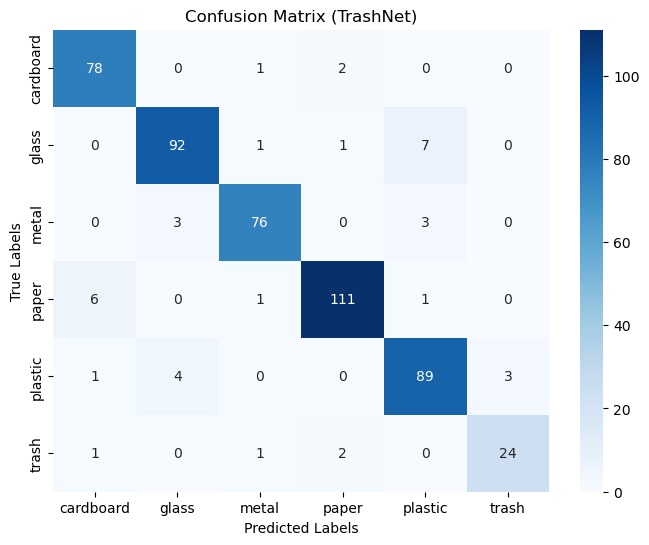

🏆 Best predicted class: cardboard (96.30%)
⚠️  Weakest class: trash (85.71%)


In [27]:
# -----------------------------------------------------------
# 🧠 STEP 10: Model Qualification (15 pts)
# Confusion Matrix, Precision/Recall/F1, Accuracy
# -----------------------------------------------------------

import torch
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1️⃣ Load the best checkpoint
ckpt = torch.load(best_ckpt_path, map_location=device)
model = timm.create_model(ckpt["model_name"], pretrained=False, num_classes=ckpt["num_classes"])
model.load_state_dict(ckpt["model_state_dict"])
model = model.to(device)
model.eval()

print(f"✅ Loaded model '{ckpt['model_name']}' with val_loss={ckpt['val_loss']:.4f}")

# 2️⃣ Collect predictions and true labels
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 3️⃣ Compute metrics
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names, digits=3)

print("\n📊 Classification Report:")
print(report)
print(f"✅ Overall Accuracy: {acc*100:.2f}%")

# 4️⃣ Confusion Matrix Visualization
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (TrashNet)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# 5️⃣ Optional: Identify best and weakest classes
cm_sum = cm.sum(axis=1, keepdims=True)
cm_norm = cm / cm_sum
per_class_acc = cm_norm.diagonal()

best_class_idx = np.argmax(per_class_acc)
worst_class_idx = np.argmin(per_class_acc)

print(f"🏆 Best predicted class: {class_names[best_class_idx]} ({per_class_acc[best_class_idx]*100:.2f}%)")
print(f"⚠️  Weakest class: {class_names[worst_class_idx]} ({per_class_acc[worst_class_idx]*100:.2f}%)")




## 11) Show the top 5 images in the validation set, that the model was most confidently wrong on.<br>  Show the image, the correct class and the predicted class(**5 pts**)


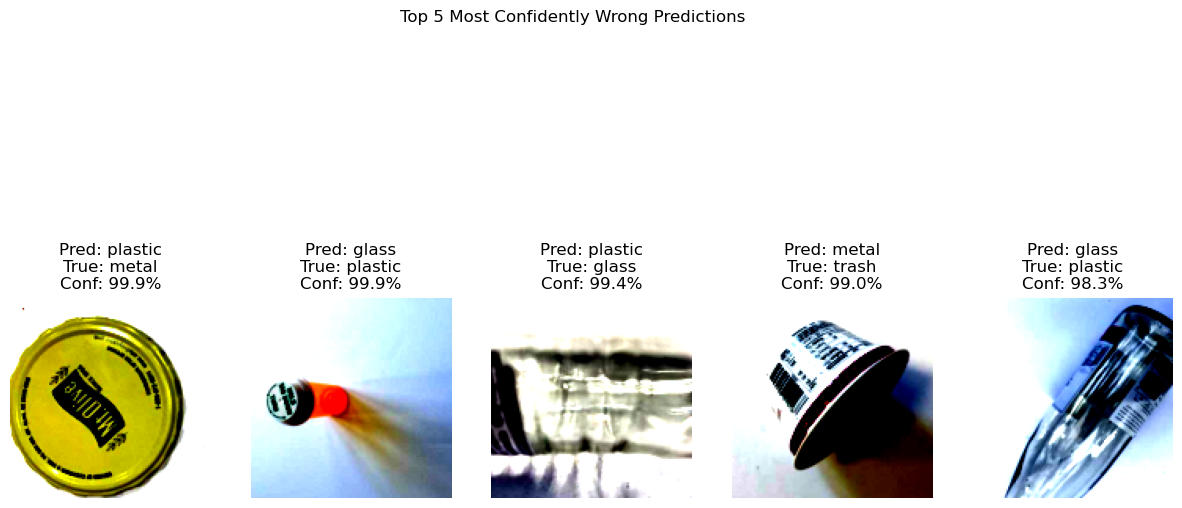

In [28]:
# -----------------------------------------------------------
# 🧩 STEP 11: Show Top-5 Most Confidently Wrong Predictions (5 pts)
# -----------------------------------------------------------

import torch
import matplotlib.pyplot as plt
import numpy as np

model.eval()

wrong_images = []
wrong_true_labels = []
wrong_pred_labels = []
wrong_confidences = []

# Collect predictions with confidence scores
with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confs, preds = torch.max(probs, dim=1)

        for i in range(len(labels)):
            if preds[i] != labels[i]:  # wrong prediction
                wrong_images.append(images[i].cpu())
                wrong_true_labels.append(labels[i].cpu().item())
                wrong_pred_labels.append(preds[i].cpu().item())
                wrong_confidences.append(confs[i].cpu().item())

# Sort wrong predictions by confidence (descending)
wrong_confidences = np.array(wrong_confidences)
sorted_idx = np.argsort(-wrong_confidences)  # highest confidence first

# Select top 5
top5_idx = sorted_idx[:5]

# -----------------------------------------------------------
# 🖼️ Visualization
# -----------------------------------------------------------
plt.figure(figsize=(15, 8))
for i, idx in enumerate(top5_idx):
    img = wrong_images[idx]
    true_label = class_names[wrong_true_labels[idx]]
    pred_label = class_names[wrong_pred_labels[idx]]
    confidence = wrong_confidences[idx]

    # Convert tensor to image
    img_np = img.permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)  # ensure proper display

    plt.subplot(1, 5, i + 1)
    plt.imshow(img_np)
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}\nConf: {confidence*100:.1f}%")
    plt.axis("off")

plt.suptitle("Top 5 Most Confidently Wrong Predictions")
plt.show()


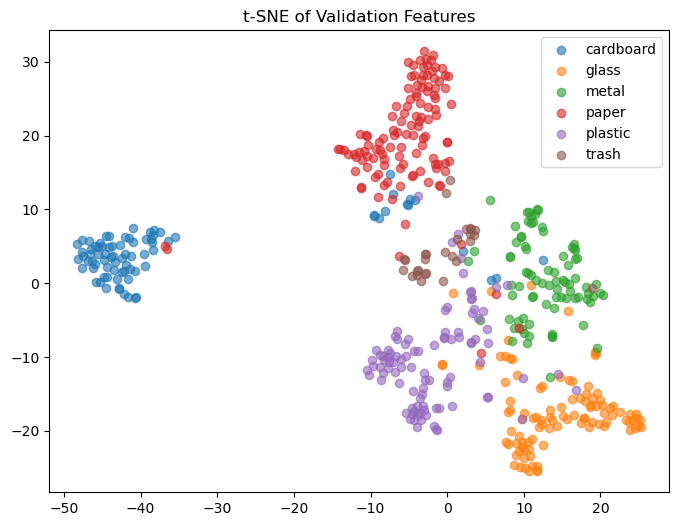

In [29]:
from sklearn.manifold import TSNE
import torch

# Extract features from validation set
features, labels = [], []
model.eval()
with torch.no_grad():
    for images, lbls in val_loader:
        images = images.to(device)
        feats = model.forward_features(images)
        pooled = torch.mean(feats, dim=[2,3])
        features.append(pooled.cpu())
        labels.append(lbls)
features = torch.cat(features)
labels = torch.cat(labels)

# t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
embeds_2d = tsne.fit_transform(features)
plt.figure(figsize=(8,6))
for i, cls in enumerate(class_names):
    plt.scatter(embeds_2d[labels==i,0], embeds_2d[labels==i,1], label=cls, alpha=0.6)
plt.legend()
plt.title("t-SNE of Validation Features")
plt.show()


In [ ]:
from the PCA graph chatGPT suggested I use, we can see that there is a moderate separation for “glass”, “metal”, and “plastic”
These have nearby but slightly overlapping regions.
They share visual cues: reflections, shine, similar color ranges, etc.
The few overlaps explain small off-diagonal confusion (e.g., glass↔plastic misclassifications).
“Trash” (brown) is scattered and overlaps multiple clusters
Indicates the model doesn’t learn one consistent representation of “trash.”
Trash is visually heterogeneous (paper cups, wrappers, random debris), so it overlaps other materials.
Explains its lower accuracy (85 %) in your confusion matrix.